In [1]:
#Dependencies
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt
import time
from sklearn.metrics import ndcg_score
import torch

from envs import OfflineEnv
from recommender import DRRAgent

import os
STATE_SIZE = 10

In [2]:
movies_df=pd.read_csv('./movies.dat')
movies_list=movies_df.values.tolist()
movies_id_to_movies = {movie[0]: movie[1:] for movie in movies_list}
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)
ratings_df=pd.read_csv('./ratings.dat')
ratings_df = ratings_df.applymap(int)

In [3]:
users_dict = np.load('./user_dict.npy', allow_pickle=True)
users_history_lens = np.load('./users_histroy_len.npy')

In [4]:
# 유저별로 본 영화들 순서대로 정리
users_dict = {user : [] for user in set(ratings_df["UserID"])}
users_dict[1]

[]

In [5]:
# sort by time
ratings_df = ratings_df.sort_values(by='Timestamp', ascending=True)
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,259,255,4,874724710
1,259,286,4,874724727
2,259,298,4,874724754
3,259,185,4,874724781
4,259,173,4,874724843


In [6]:
# Put (movie, rating) pairs in user dictionary
# Only movies with a rating of 4 or higher are counted for each user's movie history length.
ratings_df_gen = ratings_df.iterrows()
users_dict_for_history_len = {user : [] for user in set(ratings_df["UserID"])}
for data in ratings_df_gen:
    users_dict[data[1]['UserID']].append((data[1]['MovieID'], data[1]['Rating']))
    if data[1]['Rating'] >= 1:
        users_dict_for_history_len[data[1]['UserID']].append((data[1]['MovieID'], data[1]['Rating']))

In [7]:
# Movie history length for each user
users_history_lens = [len(users_dict_for_history_len[u]) for u in set(ratings_df["UserID"])]

In [8]:
len(users_history_lens)

943

In [9]:
users_num = max(ratings_df["UserID"])+1
items_num = max(ratings_df["MovieID"])+1

In [10]:
print(users_num, items_num)

944 1683


### Training setting

In [11]:
train_users_num = int(users_num * 0.8)
train_items_num = items_num
print(train_users_num, train_items_num)

755 1683


In [12]:
train_users_dict = {k:users_dict[k] for k in range(1, train_users_num+1)}
train_users_history_lens = users_history_lens[:train_users_num]
print(len(train_users_dict),len(train_users_history_lens))

755 755


### Evaluating setting

In [13]:
eval_users_num = int(users_num * 0.2)
eval_items_num = items_num
print(eval_users_num, eval_items_num)

188 1683


In [14]:
eval_users_dict = {k:users_dict[k] for k in range(users_num-eval_users_num, users_num)}
eval_users_history_lens = users_history_lens[-eval_users_num:]
print(len(eval_users_dict),len(eval_users_history_lens))

188 188


### Evalutation

In [15]:
def evaluate(recommender, env, check_movies = False, top_k=False):

    # episodic reward 
    episode_reward = 0
    steps = 0
    mean_precision = 0
    q_loss1 = 0
    q_loss2 = 0
    count = 0
    final_c1 = []
    final_c2 = []
    final_c1_avg = []
    final_c2_avg = []
    user_id_ar =  []
    user_id_init = 0
    
    # Environment 
    user_id, items_ids, done = env.reset()

    while not done:
        # Observe current state & Find action
        ## Embedding
        user_eb = recommender.embedding_network.get_layer('user_embedding')(np.array(user_id))
        items_eb = recommender.embedding_network.get_layer('movie_embedding')(np.array(items_ids))
        ## SRM state 
        state = recommender.srm_ave([np.expand_dims(user_eb, axis=0), np.expand_dims(items_eb, axis=0)])
        ## Action(ranking score) 
        action1 = recommender.actor.network(state)
        action2 = recommender.actor2.network(state)

        action = (action1 + action2)/2
        
        
        c1 = recommender.critic.network([action1, state])
        c2 = recommender.critic2.network([action2, state])
        c1_avg = recommender.critic.network([action, state])
        c2_avg = recommender.critic2.network([action, state])
        
#         print(int(c1[0][0]))
        final_c1.append(int(c1[0][0]))
        final_c2.append(int(c2[0][0]))
#         final_c1_avg.append(int(c1_avg[0][0]))
#         final_c2_avg.append(int(c2_avg[0][0]))
        
        if count == 0:
            user_id_init = user_id
        count += 1
        if count == 50 and user_id_init == user_id:
            plt.clf()
            plt.plot(final_c1)
            plt.plot(final_c2)
#             plt.plot(final_c1_avg)
#             plt.plot(final_c2_avg)
            plt.legend(['QA1C1','QA2C2']) # ,'Qc1_avg', 'Qc2_avg'
            plt.title('ML_100K User id = {}'.format(user_id_init))
            plt.xlabel("Interaction timestamp(different actions at each time stamp)")
            plt.ylabel("Q-value using different Actor-critic pair")
            plt.savefig(f'./images/criitic_{user_id_init}.png')
        
        
        
        ## Item 
        recommended_item = recommender.recommend_item(action, recommender.env.recommended_items, top_k=top_k)

        next_items_ids, reward, done, _ = recommender.env.step(recommended_item, top_k=top_k)
        if top_k:
            reward = np.sum(reward)

        # get next_state
        next_items_eb = recommender.embedding_network.get_layer('movie_embedding')(np.array(next_items_ids))
        next_state = recommender.srm_ave([np.expand_dims(user_eb, axis=0), np.expand_dims(next_items_eb, axis=0)]) 

        recommender.buffer.append(state, action, reward, next_state, done)

#         if recommender.buffer.crt_idx > 1 or recommender.buffer.is_full:
#             recommender.itr += 1

#             # Sample a minibatch of batch_size=32
#             batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones, weight_batch, index_batch = recommender.buffer.sample(recommender.batch_size)


#             # get actions with noise

#             noise = torch.FloatTensor(recommender.target_policy_noise.sample())
#             clipped_noise = torch.clamp(noise, -recommender.target_policy_noise_clip, recommender.target_policy_noise_clip)

#             target_next_action =recommender.actor.target_network(batch_next_states) + clipped_noise



#             target_qs = recommender.critic.target_network([target_next_action, batch_next_states])
#             target_qs2 = recommender.critic2.target_network([target_next_action, batch_next_states])

#             min_qs = tf.raw_ops.Min(input=tf.concat([target_qs, target_qs2], axis=1), axis=1, keep_dims=True) 

#             td_targets = recommender.calculate_td_target(batch_rewards, min_qs, batch_dones)

#             for (p, i) in zip(td_targets, index_batch):
#                 recommender.buffer.update_priority(abs(p[0]) + recommender.epsilon_for_priority, i)



#             q_loss1 += recommender.critic.train([batch_actions, batch_states], td_targets, weight_batch)
#             q_loss2 += recommender.critic2.train([batch_actions, batch_states], td_targets, weight_batch)



#             if recommender.itr % 5 == 0:
#                 s_grads1 = recommender.critic.dq_da([recommender.actor.network(batch_states), batch_states]) # returns q_grads
#                 s_grads2 = recommender.critic2.dq_da([recommender.actor2.network(batch_states), batch_states])

#                 #s_grads = (s_grads1 + s_grads2)

#                 recommender.actor.train(batch_states, s_grads1)
#                 recommender.actor2.train(batch_states, s_grads2)

#                 #Update TARGET networks line 17 of paper
#                 recommender.actor.update_target_network()  # Using the actor network
#                 recommender.actor2.update_target_network()
#                 recommender.critic.update_target_network() # Using the critic network
#                 recommender.critic2.update_target_network()

        items_ids = next_items_ids
        episode_reward += reward
        steps += 1

    return episode_reward


Model: 20000, reward:-1123.0


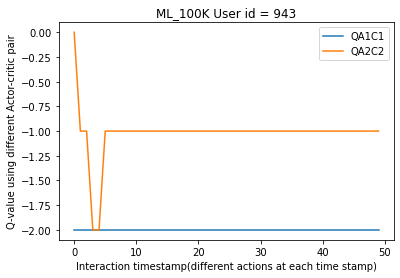

In [16]:
for i in range(40,41):
    sum_precision = 0
    sum_ndcg = 0
    sum_reward = 0
#     TOP_K = 5
    for user_id in eval_users_dict.keys():
        env = OfflineEnv(eval_users_dict, users_history_lens, movies_id_to_movies, STATE_SIZE, fix_user_id=user_id)
        recommender = DRRAgent(env, users_num, items_num, STATE_SIZE)
        recommender.actor.build_networks()
        recommender.actor2.build_networks()
        recommender.critic.build_networks()
        recommender.critic2.build_networks()
        recommender.load_model(f"./save_weights/actor_{i*500}_fixed.h5", 
                               f"./save_weights/actor2_{i*500}_fixed.h5",
                               f"./save_weights/critic_{i*500}_fixed.h5",
                              f"./save_weights/critic2_{i*500}_fixed.h5")
        reward = evaluate(recommender, env, top_k= False)
        sum_reward += reward

    print(f'Model: {i*500}, reward:{sum_reward}')